# FAIKR module 3 project

#Lorenzo Venieri
#Luca Zucchini

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases.

Objective of this project...

TODO:
-Aggiungere funzione per trovare correlazione tra features
-Considerare il fatto che il diabete causa durezza della pella, ma quest'ultima non è direttamente causa di diabete (=> != <=>)+
-Piccola spiegazione del ragionamento dietro le correlazioni NON trovate
-Fattore di rischio
-


In [ ]:
%pip install pgmpy

## Dataset

768 rows, 9 columns

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.

From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
pd.__version__

## Exploratory Data Analysis

In [ ]:
df_raw.info()

In [47]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In our dataset there are 268 patients with diabetes and 500 without. The classes are imbalanced: only about 35% of the entries have diabetes.

In [ ]:
#Visualization of the other 8 (continuous) features

fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_raw['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_raw['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_raw['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_raw['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_raw['BMI'],rug=True,ax=axs[5])
sns.distplot(df_raw['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_raw['Age'],rug=True,ax=axs[7])
plt.show()

In [ ]:
df_raw.corr()

Vediamo che ci sono tanti valori nulli nel dataset. Sarebbero da togliere dato che sono dei NaN. Allo stesso tempo possiamo usare questa cosa per iniziare un downsample dei dati con Outcome '0'

In the dataset there are many null values that we have to handle. We decided to remove them instead of using statistical methods to predict the missing values, since we have few data and we want them to be as much predictive as possible. By the way, we have to consider that null values of Insulin are interesting data since they usually indicate the presence of Diabete

In [66]:
for item in df_raw.columns :
    if item != "Outcome":
        print("In the column", item,"there are",(df_raw[item].values == 0).sum(),"null values")

In the column Pregnancies there are 111 null values
In the column Glucose there are 5 null values
In the column BloodPressure there are 35 null values
In the column SkinThickness there are 227 null values
In the column Insulin there are 374 null values
In the column BMI there are 11 null values
In the column DiabetesPedigreeFunction there are 0 null values
In the column Age there are 0 null values


In [ ]:
#TOGLIERE
for item in df_raw.columns:
    print("valori di ",item)
    temp = df_raw[item].unique()
    temp.sort()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")
    #
    #chiedere a Sten dei bin sensati per questi valori

We proceed with the removal of rows that have a null value in the columns: 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI'
Previous analysis showed that DiabetesPedigreeFunction column and Age column don't contain any null values.

In [98]:
df_clean = df_raw.copy(deep=True)

In [99]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness','BMI']
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("Column",item,"have been cleaned")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)
    

Column Glucose have been cleaned
Column BloodPressure have been cleaned
Column SkinThickness have been cleaned
Column BMI have been cleaned


With regard to the Insulin column we consider the fact that a null value of insulin in the blood is a sure sign of the presence of Diabete, so we proceed with removing all the rows that have a null value of both Insuline and Outcome


In [112]:
for i in range(len(df_clean["Insulin"])):
    if df_clean["Insulin"][i] == 0 and df_clean["Outcome"][i] == 0:
        df_clean.drop(labels= i, axis= 0, inplace= True)
print("Column","Insulin","have been cleaned")
df_clean.reset_index(drop=True, inplace=True)

Column Insulin have been cleaned


We check now if the dataset is still unbalanced with respect to the Outcome column

In [116]:
print("Total number of Outcomes without diabetes", (df_clean["Outcome"] == 0).sum())
print("Total number of Outcomes with diabetes", (df_clean["Outcome"] == 1).sum())

Total number of Outcomes without diabetes 262
Total number of Outcomes with diabetes 177


Controllo sull'insulina e sul tipo di diabete

#TOGLIERLO?

In [115]:
count_1 = 0
count_2 = 1
for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] < 1 and df_clean["Outcome"][i] == 1 :
        count_1 += 1
    if df_clean["Insulin"][i] > 200 and df_clean["Outcome"][i] == 1:
        count_2 += 1
print("presumibilmente ci sono ",count_1,"pazienti con diabete di tipo 1")
print("presumibilmente ci sono ",count_2,"pazienti con diabete di tipo 2")

presumibilmente ci sono  47 pazienti con diabete di tipo 1
presumibilmente ci sono  47 pazienti con diabete di tipo 2


As we notice there is the need of a balancing of the dataset since the '0' outcomes are 50% more than the '1' outcomes. We deal with this using the resample method provided by sklearn

In [8]:
from sklearn.utils import resample

In [117]:
df_positive_outcome = df_clean[df_clean["Outcome"] == 1]
df_negative_outcome = df_clean[df_clean["Outcome"] == 0]
#-----------

df_negative_outcome_downsampled = resample(df_negative_outcome,
             replace=True,
             n_samples=len(df_positive_outcome),
             random_state=42)
print(df_negative_outcome_downsampled.shape)
#-----------------

df_balanced = pd.concat([df_negative_outcome_downsampled, df_positive_outcome])
#-----------

df_balanced.reset_index(drop=True, inplace=True)

print("Total number of Outcomes without diabetes", (df_balanced["Outcome"] == 0).sum())
print("Total number of Outcomes with diabetes", (df_balanced["Outcome"] == 1).sum())


(177, 9)
Total number of Outcomes without diabetes 177
Total number of Outcomes with diabetes 177


We have now a balanced dataset, the next step is to modify the values of the columns from continuous values to discrete values. This transition is necessary in order to .. 

In [ ]:
for item in df_balanced:
    print("valori di ",item)
    temp = df_balanced[item].unique()
    temp.sort()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")

In [10]:
df_bin = df_balanced.copy(deep=True)

In [ ]:
df_bin.head()

In [ ]:
#primo approccio alla binnerizzazione, molto manaccione ma funziona. Sotto un apporccio più pulito

"""df_bin["Pregnancies"] = pd.cut(x=df_balanced["Pregnancies"], bins=[-1,3,6,11,18],
                        labels=["0-3","3-6","6-11","11+"])

df_bin["Glucose"] = pd.cut(x=df_balanced["Glucose"], bins=[70,100,140,np.max(df_balanced["Glucose"])],
                        labels=["70-100","100-140","140-200"])

df_bin["BloodPressure"] = pd.cut(x=df_balanced["BloodPressure"], bins=[29,60,80,85,90,100,110],
                        labels=["30-60","60-80","80-85","85-90","90-100","100-110"])

df_bin["SkinThickness"] = pd.cut(x=df_balanced["SkinThickness"], bins=[6,15,30,40,np.max(df_balanced["SkinThickness"])],
                        labels=["7,15","15,30","30-40","40+"])

df_bin["Insulin"] = pd.cut(x=df_balanced["Insulin"], bins=[-1,25,50,120,150,250,np.max(df_balanced["Insulin"])],
                        labels=["0-25","25-50","50-120","120-150","150-250","250+"])

df_bin["BMI"] = pd.cut(x=df_balanced["BMI"], bins=[19,25,30,np.max(df_balanced["BMI"])],
                        labels=["19-25","25-30","30+"])

df_bin["DiabetesPedigreeFunction"] = pd.cut(x=df_balanced["DiabetesPedigreeFunction"], bins=[-1,0.2,0.3,0.5,0.7,0.9,np.max(df_balanced["DiabetesPedigreeFunction"])],
                        labels=["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"])

df_bin["Age"] = pd.cut(x=df_balanced["Age"], bins=[20,30,40,50,60,np.max(df_balanced["Age"])],
                        labels=["20-30","30-40","40-50","50-60","60+"])
"""

In [11]:
#dictionary di configurazione per la binnerizzazione

conf = {"Pregnancies" :{
            "bins" : [-1,3,6,11,18],
            "labels": ["0-3","3-6","6-11","11+"]},

        "Glucose" :{
            "bins" : [70,100,140,np.max(df_balanced["Glucose"])],
            "labels" : ["70-100","100-140","140-200"]},

        "BloodPressure" :{
            "bins" : [29,60,80,85,90,100,110],
            "labels" : ["30-60","60-80","80-85","85-90","90-100","100-110"]},

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_balanced["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,25,50,120,150,250,np.max(df_balanced["Insulin"])],
            "labels" : ["0-25","25-50","50-120","120-150","150-250","250+"]},
            
        "BMI" :{
            "bins" : [19,25,30,np.max(df_balanced["BMI"])],
            "labels" : ["19-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.2,0.3,0.5,0.7,0.9,np.max(df_balanced["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"]},
            
        "Age" :{
            "bins" : [20,30,40,50,60,np.max(df_balanced["Age"])],
            "labels" : ["20-30","30-40","40-50","50-60","60+"]}
        }       


In [12]:
for item in conf.keys():
    df_bin[item] = pd.cut(x=df_balanced[item], bins=conf[item]["bins"],
                        labels=conf[item]["labels"])

In [ ]:
for item in df_bin:
    print("valori di ",item)
    temp = df_bin[item].unique()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")

In [ ]:
#Visualization of the binerized features distributions

fig, axs = plt.subplots(4, 2, figsize=(18,20))
axs = axs.flatten()
for n,column_name in enumerate(df_bin.columns):
    df_bin[column_name].value_counts().plot(kind='bar', title = column_name, ax = axs[n-1])


I bin sono stati creati correttamente

## Network


"In this chapter both the structure of the network, created from scratch by analyzing scientific papers related to the topic, and the parameter learning process are taken into account.

In particular, a variety of methods related to the analysis of Bayesian Networks are explored."

### Showing the network

A graphical preliminary overview of the network is shown using the visual library of pgmpy, the acronyms related to dataset attributes are the followings:

...


In [ ]:
%pip install daft

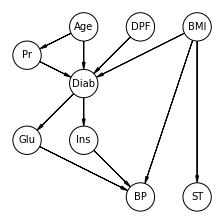

In [13]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Age', "Age", 2, 4))
pgm.add_node(daft.Node('DPF', "DPF", 3, 4))
pgm.add_node(daft.Node('BMI', "BMI", 4, 4))

pgm.add_node(daft.Node('Pr', "Pr", 1, 3.5))

pgm.add_node(daft.Node('Diab', "Diab", 2, 3))

pgm.add_node(daft.Node('Glu', "Glu", 1, 2))
pgm.add_node(daft.Node('Ins', "Ins", 2, 2))

pgm.add_node(daft.Node('BP', "BP", 3, 1))
pgm.add_node(daft.Node('ST', "ST", 4, 1))

pgm.add_edge('Age', 'Pr')
pgm.add_edge('Pr', 'Diab')
pgm.add_edge('DPF', 'Diab')
pgm.add_edge('Age', 'Diab')
pgm.add_edge('BMI','Diab')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab', 'Glu')
pgm.add_edge('Diab', 'Ins')
pgm.add_edge('Glu', 'BP')
pgm.add_edge('Ins', 'BP')

pgm.render()
plt.show()

Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

#Direct cause

#Causal trail

#Common effect

## Creating the network

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links in the medical field particularly challenging to model (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:


In [25]:
import pgmpy
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('Age','Pregnancies'),('Pregnancies', 'Diabetes'),('DiabetesPedigreeFunction', 'Diabetes'),('Age', 'Diabetes'),('BMI','Diabetes'),
('BMI','SkinThickness'),('BMI', 'BloodPressure'),('Diabetes', 'Glucose'),('Diabetes', 'Insulin'),('Glucose', 'BloodPressure'),('Insulin','BloodPressure')])

###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [26]:
# Showing all the nodes of the model
model.nodes()

NodeView(('Age', 'Pregnancies', 'Diabetes', 'DiabetesPedigreeFunction', 'BMI', 'SkinThickness', 'BloodPressure', 'Glucose', 'Insulin'))

In [18]:
# Showing all the edges of the model
model.edges()

OutEdgeView([('Age', 'Pregnancies'), ('Age', 'Diabetes'), ('Pregnancies', 'Diabetes'), ('Diabetes', 'Glucose'), ('Diabetes', 'Insulin'), ('DiabetesPedigreeFunction', 'Diabetes'), ('BMI', 'Diabetes'), ('BMI', 'SkinThickness'), ('BMI', 'BloodPressure'), ('Glucose', 'BloodPressure'), ('Insulin', 'BloodPressure')])

In [15]:
# Local independecies of a single node
model.local_independencies("Diabetes")

(Diabetes ⟂ SkinThickness | DiabetesPedigreeFunction, Age, BMI, Pregnancies)

In [28]:
model.local_independencies("SkinThickness")

(SkinThickness ⟂ Glucose, Diabetes, Insulin, Age, Pregnancies, DiabetesPedigreeFunction, BloodPressure | BMI)

In [32]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any x ∈ X and y ∈ Y given Z

print(model.is_dconnected("Glucose", "Insuline"))
print(model.is_dconnected("Glucose", "Insuline",observed=["Diabetes"] ))

False
False


In [31]:
# Function is_irrelevant recalls the definition of irrelevance given during the course 

def is_irrelevant(node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("Node", node1, "is not irrelevant with resepect to", node2, "given the evidence", evidence)
  else:
    print("Node", node1, "is irrelevant with resepect to", node2, "given the evidence", evidence)

is_irrelevant("Glucose", "Insuline", "Diabetes")

Node Glucose is irrelevant with resepect to Insuline given the evidence Diabetes


In [33]:
# Checking active trails from blood pressure given the evidence diabetes
model.active_trail_nodes('BloodPressure', observed='Diabetes')

{'BloodPressure': {'Age',
  'BMI',
  'BloodPressure',
  'DiabetesPedigreeFunction',
  'Glucose',
  'Insulin',
  'Pregnancies',
  'SkinThickness'}}

In [24]:
# Checking the markov blanket of the node BloodPressure
model.get_markov_blanket("BloodPressure")

['BMI', 'Glucose', 'Insulin']

### Parameter learning

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [34]:
from pgmpy.estimators import BayesianEstimator

In [35]:
df = df_bin.rename(columns = {'Outcome':'Diabetes'}) #column names and node names must be the same

In [ ]:
df.head()

In [ ]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

In [29]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

True

In [38]:
#Cardinality of all model nodes
model.get_cardinality()

defaultdict(int,
            {'Age': 5,
             'Pregnancies': 4,
             'Diabetes': 2,
             'DiabetesPedigreeFunction': 6,
             'BMI': 3,
             'SkinThickness': 4,
             'BloodPressure': 6,
             'Glucose': 3,
             'Insulin': 6})

## Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.

### Exact inference

Exact Inference in pgmpy is implemented through the Variable Elimination Method and Belief Propagation rather than with simple enumeration; being one of the purpouses of this work exploring topics seen in class, the former is choosen.


In [39]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [40]:
#Causal inference (prediction): probability that the patient has diabetes given her number of pregnancies
print('Probability of having diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes"],evidence={"Pregnancies": '0-3'}))

print('Probability of having diabetes with more than 11 pregnancies:')
print(infer.query(["Diabetes"],evidence={"Pregnancies": '11+'}))

Probability of having diabetes with 0 to 3 pregnancies:
+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.5797 |
+-------------+-----------------+
| Diabetes(1) |          0.4203 |
+-------------+-----------------+
Probability of having diabetes with more than 11 pregnancies:
+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.3647 |
+-------------+-----------------+
| Diabetes(1) |          0.6353 |
+-------------+-----------------+


In [39]:
#Evidential inference (explanation): probability of having diabetes given that the patient has very high insulin level
#TODO add evidence of insulin = 0
print(infer.query(["Diabetes"],evidence={"Insulin": '250+'}))

+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.4047 |
+-------------+-----------------+
| Diabetes(1) |          0.5953 |
+-------------+-----------------+


In [35]:
#Intercausal inference (explaining away): why she has high blood pressure given the fact that she hasn't diabetes
print(infer.query(["BMI"],evidence={"BloodPressure": '100-110' , "Diabetes": 0}))

+------------+------------+
| BMI        |   phi(BMI) |
+============+============+
| BMI(19-25) |     0.1628 |
+------------+------------+
| BMI(25-30) |     0.3293 |
+------------+------------+
| BMI(30+)   |     0.5078 |
+------------+------------+


The maximum a posteriori (MAP) queries boil down to finding the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variables), given observations of some evidence variables. This is sometimes also referred to as partial abductive inference.

The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [41]:
#Infer MAP queries
print(infer.map_query(["Insulin"]))
print(infer.map_query(["Insulin"], evidence={'Glucose': '70-100'}))
print(infer.map_query(["Insulin"], evidence={'Diabetes': 1}))

Eliminating: DiabetesPedigreeFunction: 100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


{'Insulin': '50-120'}


Eliminating: Diabetes: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]      


{'Insulin': '50-120'}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

{'Insulin': '150-250'}


## Approximate Inference

In [42]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

In [43]:
infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [44]:
# Sampling from an empty network
print(infer.query(variables=["Diabetes"], n_samples=100)) 

Generating for node: DiabetesPedigreeFunction:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
Generating for node: BloodPressure: 100%|██████████| 9/9 [00:00<00:00, 163.64it/s]  

+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.4800 |
+-------------+-----------------+
| Diabetes(1) |          0.5200 |
+-------------+-----------------+


In [45]:
# Showing the convergence increasing number of samples
print(infer.query(variables=["BloodPressure"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["BloodPressure"], n_samples=10000)) #approximate probability with an high number of samples

print(VariableElimination(model).query(["BloodPressure"]))      #true probability

Generating for node: DiabetesPedigreeFunction:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
Generating for node: BloodPressure: 100%|██████████| 9/9 [00:00<00:00, 191.49it/s]  


+----------------------+----------------------+
| BloodPressure        |   phi(BloodPressure) |
+======================+======================+
| BloodPressure(30-60) |               0.2000 |
+----------------------+----------------------+
| BloodPressure(60-80) |               0.5000 |
+----------------------+----------------------+
| BloodPressure(80-85) |               0.2000 |
+----------------------+----------------------+
| BloodPressure(85-90) |               0.1000 |
+----------------------+----------------------+


Generating for node: DiabetesPedigreeFunction:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
Generating for node: BloodPressure: 100%|██████████| 9/9 [00:00<00:00, 113.93it/s]  

+------------------------+----------------------+
| BloodPressure          |   phi(BloodPressure) |
+========================+======================+
| BloodPressure(100-110) |               0.0286 |
+------------------------+----------------------+
| BloodPressure(30-60)   |               0.1678 |
+------------------------+----------------------+
| BloodPressure(60-80)   |               0.5439 |
+------------------------+----------------------+
| BloodPressure(80-85)   |               0.1118 |
+------------------------+----------------------+
| BloodPressure(85-90)   |               0.1089 |
+------------------------+----------------------+
| BloodPressure(90-100)  |               0.0390 |
+------------------------+----------------------+
+------------------------+----------------------+
| BloodPressure          |   phi(BloodPressure) |
+========================+======================+
| BloodPressure(100-110) |               0.0283 |
+------------------------+----------------------+


In [46]:
print(infer.query(variables=["Diabetes"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["Diabetes"], n_samples=100)) #approximate probability with a medium number of samples

print(infer.query(variables=["Diabetes"], n_samples=10000)) #approximate probability with an high number of samples

print('True probability:')
print(VariableElimination(model).query(["Diabetes"]))      #true probability

Generating for node: DiabetesPedigreeFunction:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
Generating for node: BloodPressure: 100%|██████████| 9/9 [00:00<00:00, 183.67it/s]  


+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.5000 |
+-------------+-----------------+
| Diabetes(1) |          0.5000 |
+-------------+-----------------+


Generating for node: DiabetesPedigreeFunction:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
Generating for node: BloodPressure: 100%|██████████| 9/9 [00:00<00:00, 169.81it/s]  


+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.5200 |
+-------------+-----------------+
| Diabetes(1) |          0.4800 |
+-------------+-----------------+


Generating for node: DiabetesPedigreeFunction:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
Generating for node: BloodPressure: 100%|██████████| 9/9 [00:00<00:00, 113.93it/s]  


+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.4878 |
+-------------+-----------------+
| Diabetes(1) |          0.5122 |
+-------------+-----------------+
True probability:
+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.4948 |
+-------------+-----------------+
| Diabetes(1) |          0.5052 |
+-------------+-----------------+


We can observe that with a small number of samples we don't even find all the possible events for BloodPressure.

In [ ]:
# Likelihood weighting
#let's see the results of a sampling process
print(inference.likelihood_weighted_sample( size=10)) #size: number of samples


In [ ]:
# We observe the distribution obtained to derive the approx probabilities
print(infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes"], joint=True))

In [ ]:
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes"]))

We observe that, given the same number of samples, sampling from an empty network, likelihood weighting and rejection sampling give us different results. This was expected as we would need more samples to reach convergnece for all theese three methods.

# Conclusions

Now that we have explored some functionalities of pgmpy to deal with our network we will explore our model to see if we can get some useful insights about diabetes and the related fetures from what the model has learned using the provided dataset.